In [1]:
import numpy as np
import spherical

Here are given three examples of spherical density profiles of uniform atomic/isotopic composition, appropriate for NSM ejecta. We assume that the radioactive material has the same density profile as the total density, $\rho = \rho_{\rm rad}$.

The output includes: the semi-analytic solution $f_{\gamma}(E,t)$ and $f_\xi(\xi)$, the ejecta average column density $\langle\Sigma\rangle t^2$, and the parameter of the analytic approximation $n$. 

In [2]:
# uniform density shell profile
c = 29979245800

M = 0.05 * 1.988e33
vmin = 0.1*c
vmax = 0.3*c

rho_t = lambda v, t: M / (4 * np.pi / 3 * ((vmax * t)**3 - (vmin * t)**3)) * (v >= vmin) * (v <= vmax)
X_rad = lambda v: 1 # radioactive matter mass fraction
rho_t_rad = lambda v, t: rho_t(v,t) * X_rad(v)

# define velocity space for the integration
v_space = np.linspace(vmin, vmax,50)

#take arb. time t_0
t_0 = 1
rho_0 = lambda v: rho_t(v,t_0)
rho_0_rad = lambda v: rho_t_rad(v,t_0)

# assert(np.abs(spherical.calc_M(rho_0(v_space),t_0,v_space)/M-1)<0.01) # make sure the v_space is enough for 1% accuracy in M

xi_calculate = np.logspace(-2, 2, 40) # points for the calc. of f_xi
M_rad, column_density_t_squared, f_xi_interp, n, f_gamma_E_t = spherical.calc_all_single_component(rho_0, rho_0_rad, t_0, v_space, xi_calculate, M)

print('Shell of uniform density, with v_min = %.2fc and v_max = %.2fc'%(vmin/c,vmax/c)) 
print('The radioactive mass: %.3f solar mass'%(M_rad/1.988e33))
print('The average column density <Sigma>t^2: %.2e' %column_density_t_squared,'g cm^{-2} s^2')
print('n is: %.2f'%n)

Shell of uniform density, with v_min = 0.10c and v_max = 0.30c
The radioactive mass: 0.050 solar mass
The average column density <Sigma>t^2: 2.17e+11 g cm^{-2} s^2
n is: 2.37


In [3]:
# Waxman et al. 2018 density profile: m(>=v) \propto v^(-1/alpha)
# M is the mass between vM and c.
# However, the parameter M in Waxman et al is the mass from vM to infty
# So M is converted to "M_powerlaw" that gives mass M from vM to c
c = 29979245800
M = 0.05 * 1.988e33
alpha = 0.7
vM = 0.15*c
M_powerlaw = M / (1-(vM/c)**(1/alpha))

rho_t = lambda v, t: M_powerlaw / (4 * np.pi * alpha * v**3) * (v/vM)**(-1/alpha) * (v >= vM)
X_rad = lambda v: 1 # radioactive matter mass fraction
rho_t_rad = lambda v, t: rho_t(v,t) * X_rad(v)

# define velocity space for the integration
v_space = np.logspace(np.log10(vM), np.log10(c),100)

#take arb. time t_0
t_0 = 1
rho_0 = lambda v: rho_t(v,t_0)
rho_0_rad = lambda v: rho_t_rad(v,t_0)

xi_calculate = np.logspace(-2, 2, 40) # points for the calc. of f_xi
M_rad, column_density_t_squared, f_xi_interp, n, f_gamma_E_t = spherical.calc_all_single_component(rho_0, rho_0_rad, t_0, v_space, xi_calculate, M)

print('Waxman et al 2018 ejecta model, with v_M = %.2fc and alpha = %.1f'%(vM/c,alpha)) 
print('The radioactive mass: %.3f solar mass'%(M_rad/1.988e33))
print('The average column density <Sigma>t^2: %.2e' %column_density_t_squared,'g cm^{-2} s^2')
print('n is: %.2f'%n)

Waxman et al 2018 ejecta model, with v_M = 0.15c and alpha = 0.7
The radioactive mass: 0.050 solar mass
The average column density <Sigma>t^2: 1.69e+11 g cm^{-2} s^2
n is: 1.89


In [4]:
# Barnes & Kasen 2013 density profile
c = 29979245800

M = 0.05 * 1.988e33
v_char = 0.2 * c
E = 0.5 * M * v_char**2

# Find the paramters zeta_v and zeta_rho for these M and E, see Barnes & Kasen 2013, eqs. 4-5
vt_zeta_v = lambda zeta_v: 7.1e8 * zeta_v * (E/1e51)**0.5 * (M/1.988e33)**-0.5
rho_zeta_rho = lambda v, t, zeta_rho, zeta_v: zeta_rho * M * (vt_zeta_v(zeta_v)*t)**-3 * (v / vt_zeta_v(zeta_v))**-1 * (v < vt_zeta_v(zeta_v)) + zeta_rho * M * (vt_zeta_v(zeta_v)*t)**-3 * (v / vt_zeta_v(zeta_v))**-10 * (v > vt_zeta_v(zeta_v))

from scipy.integrate import trapz
from scipy.optimize import fsolve
def equation_to_solve(zeta_rho_v): # solve for \int{dm}=M and \int{dm * v^2/2} = E
    v_space = np.arange(5e6, c + 5e6, 5e6)
    t_0 = 1 # arb. time
    return np.array([spherical.calc_M(rho_zeta_rho(v_space,t_0, zeta_rho_v[0],zeta_rho_v[1]),t_0,v_space)/M - 1,
            trapz(4 * np.pi * v_space**2 * rho_zeta_rho(v_space,t_0, zeta_rho_v[0],zeta_rho_v[1]) * t_0**3 * 0.5 * v_space**2, v_space)/E - 1])
zeta_rho, zeta_v = fsolve(equation_to_solve, np.array([1.0,1.0]))

vt = vt_zeta_v(zeta_v)
rho_t = lambda v, t: rho_zeta_rho(v,t,zeta_rho,zeta_v)
X_rad = lambda v: 1 # radioactive matter mass fraction
rho_t_rad = lambda v, t: rho_t(v,t) * X_rad(v)

# define velocity space for the integration
v_space = np.linspace(v_char/50,v_char*3,100)

#take arb. time t_0
t_0 = 1
rho_0 = lambda v: rho_t(v,t_0)
rho_0_rad = lambda v: rho_t_rad(v,t_0)

xi_calculate = np.logspace(-2, 2, 40) # points for the calc. of f_xi
M_rad, column_density_t_squared, f_xi_interp, n, f_gamma_E_t = spherical.calc_all_single_component(rho_0, rho_0_rad, t_0, v_space, xi_calculate, M)

print('Barnes & Kasen 2013 ejecta model, with M = %.4f solar mass and v_char = %.2fc'%(M/1.988e33,v_char/c)) 
print('The radioactive mass: %.3f solar mass'%(M_rad/1.988e33))
print('The average column density <Sigma>t^2: %.2e' %column_density_t_squared,'g cm^{-2} s^2')
print('n is: %.2f'%n)

Barnes & Kasen 2013 ejecta model, with M = 0.0500 solar mass and v_char = 0.20c
The radioactive mass: 0.050 solar mass
The average column density <Sigma>t^2: 3.19e+11 g cm^{-2} s^2
n is: 2.10


As an example, we compute $f_\gamma$ for two lines with $\kappa_{\gamma,E} = 0.025, 0.05 {\rm cm^2 g^{-1}}$ and with (energy-weighted) spectrum $\phi_{\gamma}=0.5, 0.5$ (i.e. both lines carry the same fraction of the $\gamma$-ray energy)

kappa_gamma,eff = 0.035 cm^2 g^-1
t_gamma = 1.23 d


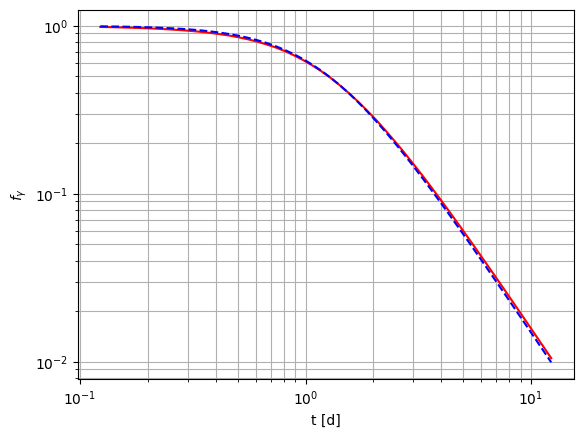

In [5]:
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.integrate import trapz
from scipy.optimize import fsolve

kappa_gamma_E_t = np.array([0.025,0.05])
phi_gamma_E_t = np.array([0.5,0.5])

# The semi-analytic solution
f_gamma_semi_analytic = lambda t: phi_gamma_E_t[0]*f_gamma_E_t(kappa_gamma_E_t[0],t) + phi_gamma_E_t[1]*f_gamma_E_t(kappa_gamma_E_t[1],t)                          
      
# The analytic solution
# first, find kappa_gamma,eff:
def equation_to_solve(kappa_gamma_eff):
    return np.sum((1-np.exp(-kappa_gamma_E_t / kappa_gamma_eff)) * phi_gamma_E_t) - (1 - np.exp(-1))
initial_guess = 0.05
kappa_gamma_eff = fsolve(equation_to_solve, initial_guess)
t_gamma = np.sqrt(kappa_gamma_eff*column_density_t_squared)
# compute using t_gamma and n
f_gamma_analytic = lambda t: (1+(t/t_gamma)**n)**(-2/n)


plt.figure()
t_plot = t_gamma*np.logspace(-1,1,50)
plt.loglog(t_plot/24/3600,f_gamma_semi_analytic(t_plot),label='Semi-Analytic',color='r')
plt.loglog(t_plot/24/3600,f_gamma_analytic(t_plot),label='Analytic',linestyle='--',color='b')
plt.ylabel('$f_\\gamma$')
plt.xlabel('t [d]')
plt.grid(which='both')
print('kappa_gamma,eff = %.3f cm^2 g^-1'%kappa_gamma_eff[0])
print('t_gamma = %.2f d'%(t_gamma[0]/24/3600))